In [1]:
import json
import glob
import matplotlib.pyplot as plt

# 1. Gộp toàn bộ file batch
merged_data = []

batch_files = sorted(glob.glob("/kaggle/input/crawl-v-n-b-n-ph-p-lu-t/data/law_data_batch_*.json"))
print("Found files:", batch_files)

for file in batch_files:
    with open(file, "r", encoding="utf-8") as f:
        batch_data = json.load(f)
        merged_data.extend(batch_data)

print(f"Tổng số văn bản: {len(merged_data)}")
# Tokenizer đơn giản theo whitespace
def count_tokens(text):
    return len(text.strip().split())

# Tính số token
question_lengths = [count_tokens(item["question"]) for item in merged_data]
context_lengths = [count_tokens(item["context"]) for item in merged_data]


Found files: ['/kaggle/input/crawl-v-n-b-n-ph-p-lu-t/data/law_data_batch_1.json', '/kaggle/input/crawl-v-n-b-n-ph-p-lu-t/data/law_data_batch_2.json', '/kaggle/input/crawl-v-n-b-n-ph-p-lu-t/data/law_data_batch_3.json', '/kaggle/input/crawl-v-n-b-n-ph-p-lu-t/data/law_data_batch_4.json', '/kaggle/input/crawl-v-n-b-n-ph-p-lu-t/data/law_data_batch_5.json']
Tổng số văn bản: 9980


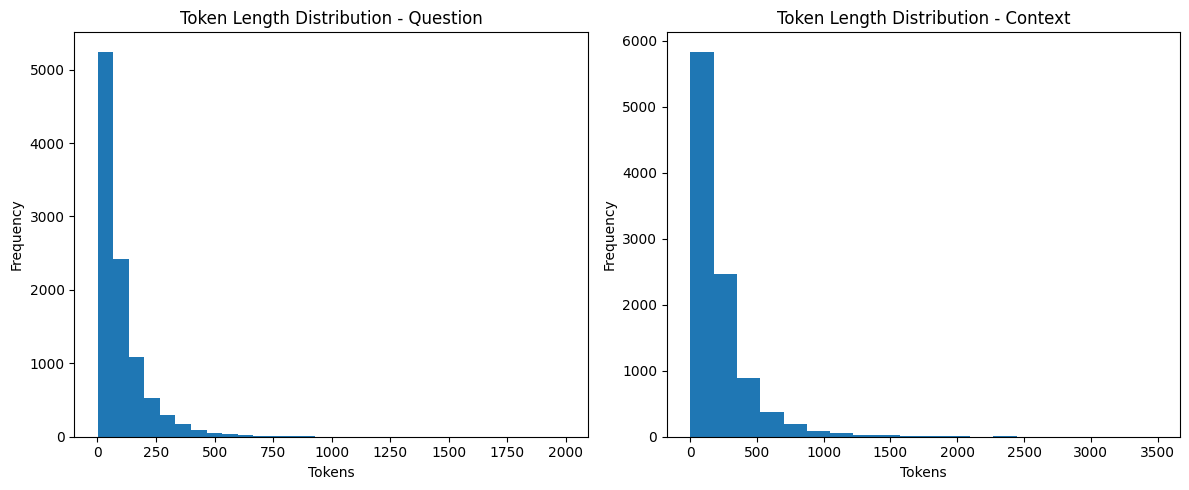

In [2]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(question_lengths, bins=30)
plt.title("Token Length Distribution - Question")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(context_lengths, bins=20)
plt.title("Token Length Distribution - Context")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [3]:
def compute_token_coverage(data, n1, n2):
    def count_tokens(text):
        return len(text.strip().split())

    total = len(data)
    under_n1 = sum(1 for item in data if count_tokens(item["question"]) < n1)
    under_n2 = sum(1 for item in data if count_tokens(item["context"]) < n2)
    both_conditions = sum(
        1 for item in data if count_tokens(item["question"]) < n1 and count_tokens(item["context"]) < n2
    )

    percentage1 = (under_n1 / total) * 100 if total > 0 else 0
    percentage2 = (under_n2 / total) * 100 if total > 0 else 0
    percentage_both = (both_conditions / total) * 100 if total > 0 else 0

    print(f"Question < {n1} tokens: {percentage1:.2f}% ({under_n1}/{total})")
    print(f"Context  < {n2} tokens: {percentage2:.2f}% ({under_n2}/{total})")
    print(f"Both question < {n1} & context < {n2}: {percentage_both:.2f}% ({both_conditions}/{total})")

    



compute_token_coverage(merged_data,128, 256)


Question < 128 tokens: 75.33% (7518/9980)
Context  < 256 tokens: 74.90% (7475/9980)
Both question < 128 & context < 256: 59.31% (5919/9980)


In [4]:
from transformers import AutoTokenizer

# Tokenizer cho PhoBERT hoặc BERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

def chunk_text(text, max_tokens=256):
    tokens = tokenizer.tokenize(text)
    chunks = []

    for i in range(0, len(tokens), max_tokens):
        chunk = tokens[i:i + max_tokens]
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        chunks.append(chunk_text.strip())

    return chunks

def truncate_query(query, max_tokens=128):
    tokens = tokenizer.tokenize(query)[:max_tokens]
    return tokenizer.convert_tokens_to_string(tokens).strip()

def build_chunked_dataset(data, query_max_len=128, passage_max_len=256):
    results = []

    for item in data:
        query = truncate_query(item["question"], max_tokens=query_max_len)
        context = item["context"]

        positive_chunks = chunk_text(context, max_tokens=passage_max_len)

        if positive_chunks:  # bỏ nếu không có đoạn nào sau chunking
            results.append({
                "query": query,
                "pos": positive_chunks
            })

    return results

# Thực thi
chunked_data = build_chunked_dataset(merged_data)




config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [5]:
output_path = "dataset.jsonl"

with open(output_path, "w", encoding="utf-8") as f:
    for item in chunked_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print(f"Đã lưu {len(chunked_data)} dòng vào {output_path}")


Đã lưu 9980 dòng vào dataset.jsonl


In [12]:
import json
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def generate_hard_negatives_with_bge_jsonl(
    train_file: str,
    output_file: str = "train_with_hard_negatives.jsonl",
    model_name: str = "BAAI/bge-m3",
    batch_size: int = 64,
    max_length: int = 256,
    num_negatives: int = 4
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model & tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    # Load data
    with open(train_file, "r", encoding="utf-8") as f:
        data = [json.loads(line) for line in f]

    queries = [item["query"] for item in data]
    positives_flat = [item["pos"][0] for item in data]  # để làm mẫu negative

    # Hàm encode văn bản
    def get_embeddings(texts, desc):
        all_embeddings = []
        for i in tqdm(range(0, len(texts), batch_size), desc=desc):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                embeddings = outputs.last_hidden_state[:, 0].cpu().numpy()
                all_embeddings.append(embeddings)
        return np.vstack(all_embeddings)

    print("Encoding queries and flat positives...")
    query_embeddings = get_embeddings(queries, desc="🔍 Encoding queries")
    pos_embeddings = get_embeddings(positives_flat, desc="🔍 Encoding positives")

    print("Calculating cosine similarity and mining hard negatives...")
    cosine_matrix = cosine_similarity(query_embeddings, pos_embeddings)

    result = []
    for i in tqdm(range(len(data)), desc="🧠 Generating hard negatives"):
        sim_scores = cosine_matrix[i]
        sim_scores[i] = -1  # loại bỏ positive thật

        top_indices = np.argpartition(-sim_scores, range(num_negatives))[:num_negatives]
        hard_negatives = [positives_flat[j] for j in top_indices]

        item = {
            "query": data[i]["query"],
            "pos": data[i]["pos"],
            "neg": hard_negatives
        }
        result.append(item)

    with open(output_file, "w", encoding="utf-8") as f:
        for item in result:
            json.dump(item, f, ensure_ascii=False)
            f.write("\n")

    print(f"Đã tạo {len(result)} mẫu với ≥{num_negatives} hard negatives. Đã lưu vào: {output_file}")
    return result


In [13]:
generate_hard_negatives_with_bge_jsonl(
    train_file="dataset.jsonl",
    output_file= "train.jsonl",
    model_name= "BAAI/bge-m3",
    batch_size= 64,
    max_length= 256,
    num_negatives= 4
)

Encoding queries and flat positives...


🔍 Encoding positives: 100%|██████████| 156/156 [04:01<00:00,  1.55s/it]


Calculating cosine similarity and mining hard negatives...


🧠 Generating hard negatives: 100%|██████████| 9980/9980 [00:01<00:00, 8066.83it/s]


Đã tạo 9980 mẫu với ≥4 hard negatives. Đã lưu vào: train.jsonl


[{'query': 'Xe đạp máy chạy trong hầm đường bộ không có đèn phát sáng bị xử phạt thế nào? Quy định tại văn bản nào? Mong ban biên tập giải đáp thắc mắc của tôi. Xin cám ơn!',
  'pos': ['Theo quy định tại điểm e khoản 1 Điều 8 Nghị định 46/2016/NĐ-CP về quy định xử phạt vi phạm hành chính trong lĩnh vực giao thông đường bộ và đường sắt có hiệu lực từ ngày 01/08/2016 thì:\n "1. Cảnh cáo hoặc phạt tiền từ 50.000 đồng đến 60.000 đồng đối với một trong các hành vi vi phạm sau đây:\n e) Chạy trong hầm đường bộ không có đèn hoặc vật phát sáng báo hiệu; dừng xe, đỗ xe trong hầm đường bộ không đúng nơi quy định; quay đầu xe trong hầm đường bộ";'],
  'neg': ['Ban biên tập xin trả lời như sau:\n Theo quy định tại điểm e khoản 1 Điều 8 Nghị định 46/2016/NĐ-CP về quy định xử phạt vi phạm hành chính trong lĩnh vực giao thông đường bộ và đường sắt có hiệu lực từ ngày 01/08/2016 thì:\n "1. Cảnh cáo hoặc phạt tiền từ 50.000 đồng đến 60.000 đồng đối với một trong các hành vi vi phạm sau đây:\n e) Chạy t